# 特征工程与t-SNE降维分析

本笔记本专注于数据预处理、特征工程和t-SNE降维可视化分析。

## 主要内容：
1. 数据加载与预处理
2. 特征工程（对数变换、独热编码、标准化）
3. t-SNE降维分析
4. 降维结果可视化
5. 处理后数据保存

## 数据流：
- 输入：train.csv, test.csv
- 输出：processed_data.pkl（包含预处理后的训练集、测试集和目标变量）

In [43]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图片显示参数
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
color = ['tomato','lightseagreen','maroon','cyan','green']
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})


In [44]:
# 数据加载
print("正在加载数据...")
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

print(f"训练集形状: {train_data.shape}")
print(f"测试集形状: {test_data.shape}")
print(f"训练集目标变量统计:")
print(train_data['SalePrice'].describe())

正在加载数据...
训练集形状: (1460, 81)
测试集形状: (1459, 80)
训练集目标变量统计:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [45]:
# 合并训练和测试数据进行统一预处理（不包含目标变量）
print("合并数据集进行预处理...")
all_data = pd.concat((train_data.loc[:, 'MSSubClass':'SaleCondition'],
                      test_data.loc[:, 'MSSubClass':'SaleCondition']))

print(f"合并后数据形状: {all_data.shape}")
print(f"缺失值统计:")
missing_data = all_data.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False).head(10))

合并数据集进行预处理...
合并后数据形状: (2919, 79)
缺失值统计:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
dtype: int64


对目标变量进行对数变换...
对数变换前后的目标变量分布:


对目标变量进行对数变换...
对数变换前后的目标变量分布:


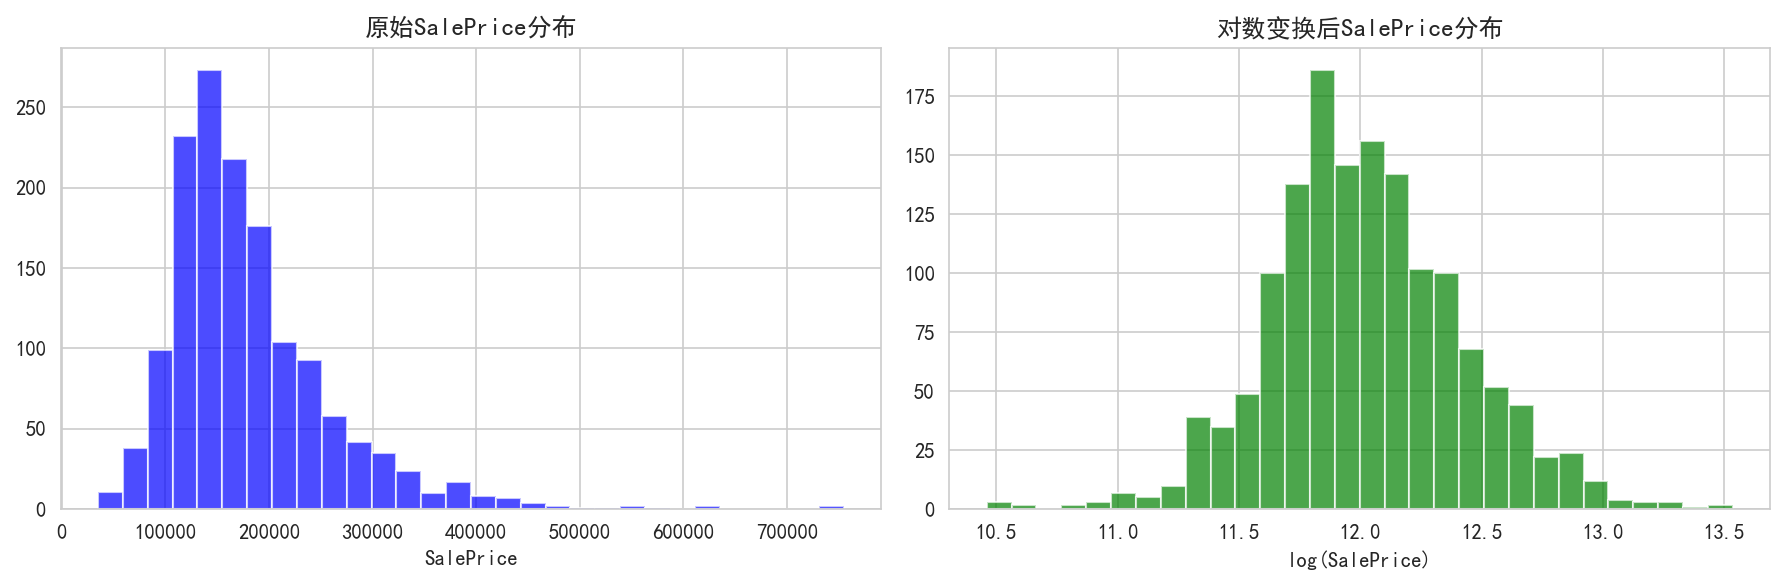

In [46]:
# 目标变量对数变换
print("对目标变量进行对数变换...")
original_target = train_data["SalePrice"].copy()  # 保存原始目标变量
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

print("对数变换前后的目标变量分布:")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(original_target, bins=30, alpha=0.7, color='blue')
ax1.set_title('原始SalePrice分布')
ax1.set_xlabel('SalePrice')

ax2.hist(train_data["SalePrice"], bins=30, alpha=0.7, color='green')
ax2.set_title('对数变换后SalePrice分布')
ax2.set_xlabel('log(SalePrice)')

plt.tight_layout()
plt.savefig('../images/target_transformation.png', bbox_inches='tight')
plt.show()

In [47]:
# 数值特征的偏度分析和对数变换
print("分析数值特征的偏度...")
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index
skewed_features = train_data[numeric_features].apply(lambda x: skew(x.dropna()))

print("偏度大于0.75的特征:")
high_skew = skewed_features[skewed_features > 0.75]
print(high_skew.sort_values(ascending=False))

# 对高偏度特征进行对数变换
skewed_features_names = high_skew.index
all_data[skewed_features_names] = np.log1p(all_data[skewed_features_names])
print(f"对 {len(skewed_features_names)} 个高偏度特征进行了对数变换")

分析数值特征的偏度...
偏度大于0.75的特征:
MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.666326
OpenPorchSF       2.361912
LotFrontage       2.160866
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
dtype: float64
对 21 个高偏度特征进行了对数变换


In [48]:
# 类别特征独热编码
print("进行独热编码...")
categorical_features = all_data.dtypes[all_data.dtypes == "object"].index
print(f"类别特征数量: {len(categorical_features)}")
print("类别特征:", list(categorical_features))

all_data = pd.get_dummies(all_data)
print(f"独热编码后特征数量: {all_data.shape[1]}")

进行独热编码...
类别特征数量: 43
类别特征: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
独热编码后特征数量: 287


In [49]:
# 缺失值填充
print("处理缺失值...")
missing_before = all_data.isnull().sum().sum()
all_data = all_data.fillna(all_data.mean())
missing_after = all_data.isnull().sum().sum()

print(f"填充前缺失值总数: {missing_before}")
print(f"填充后缺失值总数: {missing_after}")

处理缺失值...
填充前缺失值总数: 678
填充后缺失值总数: 0


In [50]:
# 特征标准化
print("进行特征标准化...")
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data)

print(f"标准化后数据形状: {all_data_scaled.shape}")
print("标准化后数据统计信息:")
print(f"均值: {np.mean(all_data_scaled, axis=0)[:5]}...")  # 显示前5个特征的均值
print(f"标准差: {np.std(all_data_scaled, axis=0)[:5]}...")  # 显示前5个特征的标准差

进行特征标准化...
标准化后数据形状: (2919, 287)
标准化后数据统计信息:
均值: [-3.91297515e-16  1.92058314e-15 -2.84071042e-15 -1.66742643e-16
  3.02449246e-16]...
标准差: [1. 1. 1. 1. 1.]...


In [51]:
# 分割数据
train_data_scaled = all_data_scaled[:len(train_data)]
test_data_scaled = all_data_scaled[len(train_data):]

print(f"预处理后训练集形状: {train_data_scaled.shape}")
print(f"预处理后测试集形状: {test_data_scaled.shape}")

预处理后训练集形状: (1460, 287)
预处理后测试集形状: (1459, 287)


In [52]:
# t-SNE降维分析
print("开始t-SNE降维分析...")
print("注意：t-SNE计算可能需要几分钟时间...")

tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, n_iter=2000, random_state=42)
train_data_tsne = tsne.fit_transform(train_data_scaled)

print("t-SNE降维完成")
print(f"降维后数据形状: {train_data_tsne.shape}")

开始t-SNE降维分析...
注意：t-SNE计算可能需要几分钟时间...
t-SNE降维完成
降维后数据形状: (1460, 2)
t-SNE降维完成
降维后数据形状: (1460, 2)


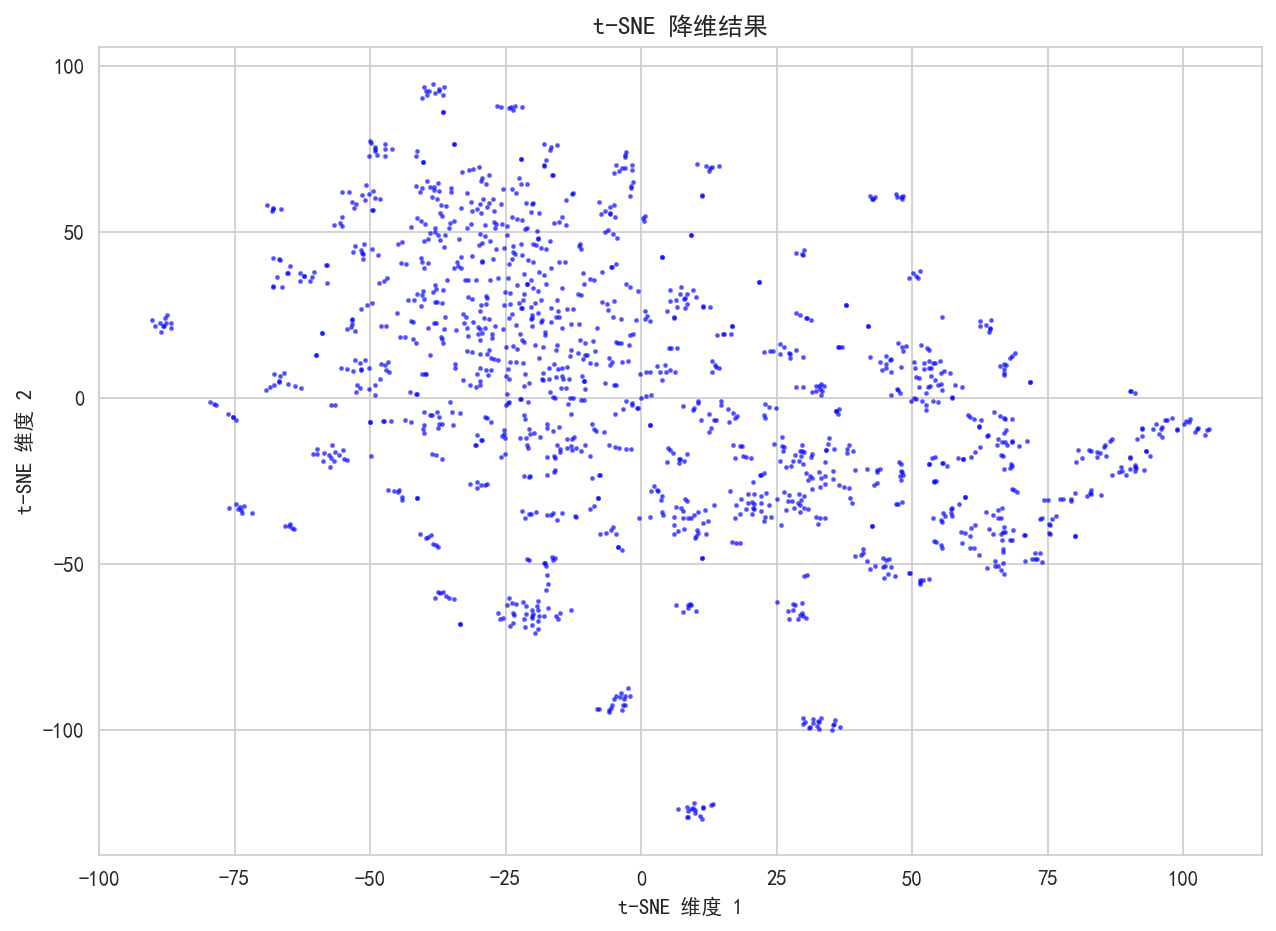

t-SNE降维结果已保存


In [53]:
# t-SNE降维结果可视化
plt.figure(figsize=(10, 7))
plt.scatter(train_data_tsne[:, 0], train_data_tsne[:, 1], s=2, alpha=0.5, color='b')
plt.xlabel('t-SNE 维度 1')
plt.ylabel('t-SNE 维度 2')
plt.title('t-SNE 降维结果')
plt.grid(True)
plt.savefig('../images/tsne_result.png', bbox_inches='tight')
plt.show()

print("t-SNE降维结果已保存")

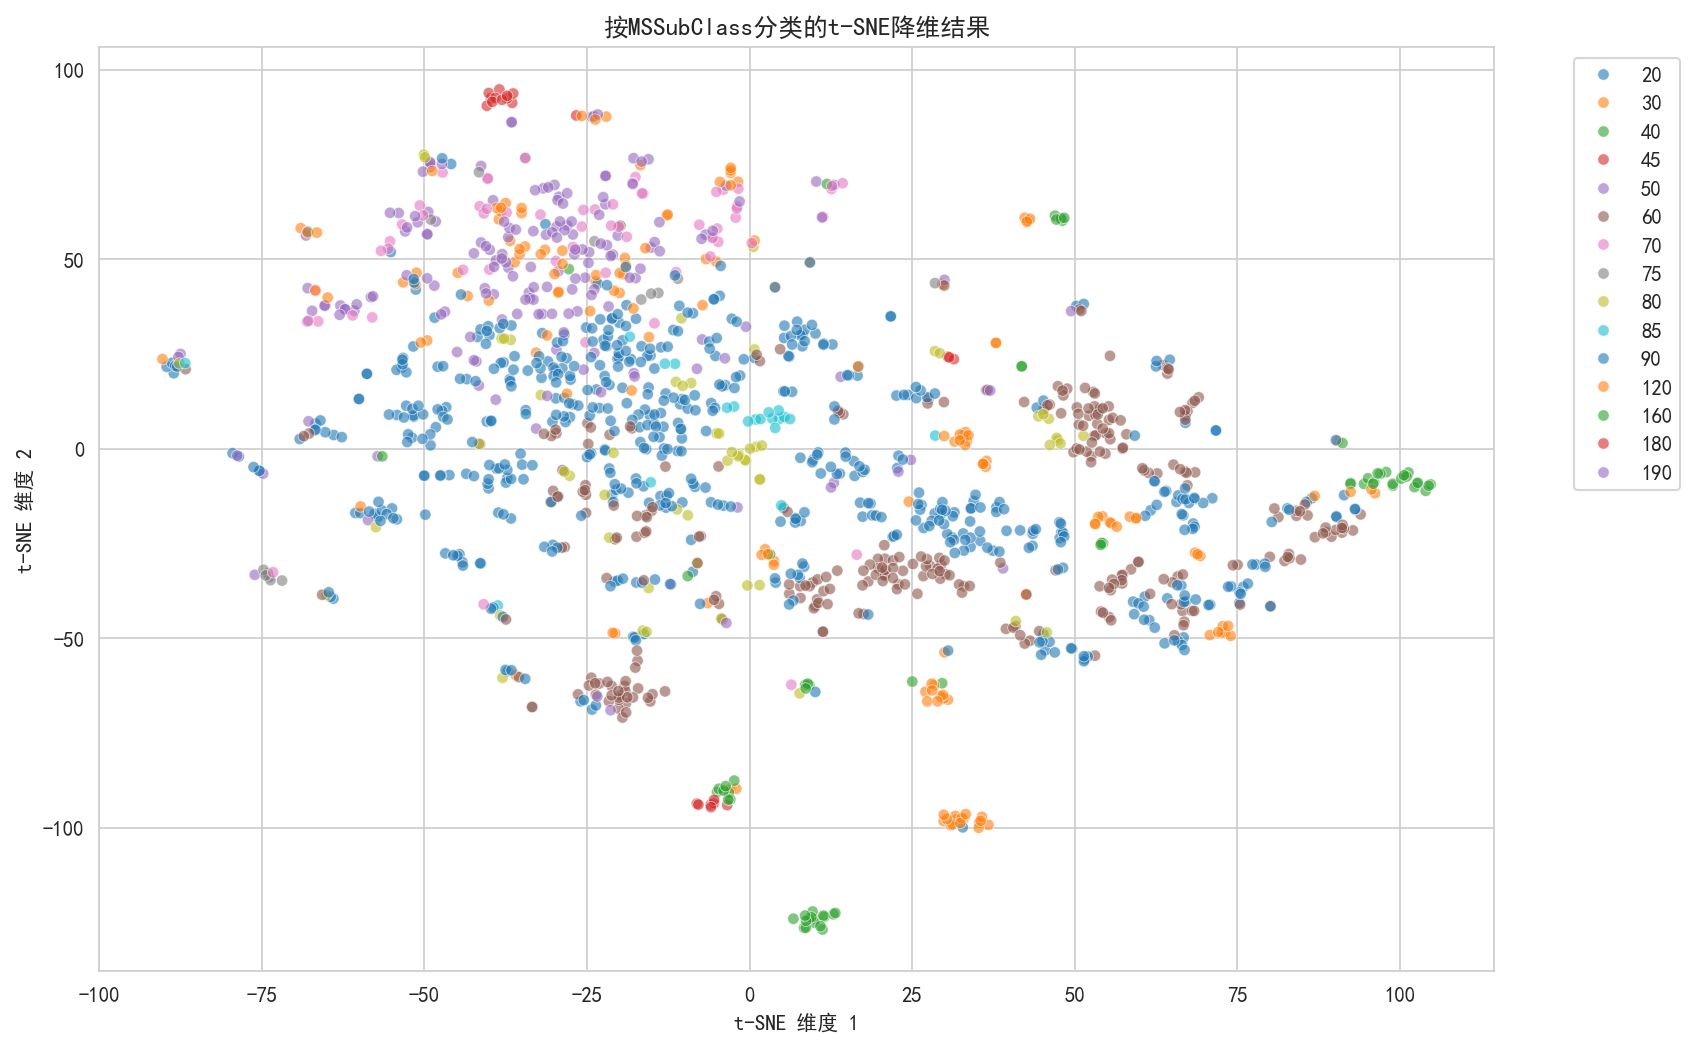

In [54]:
# 按MSSubClass分类的t-SNE可视化
ms_subclass = train_data['MSSubClass']

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=train_data_tsne[:, 0], y=train_data_tsne[:, 1], 
                         hue=ms_subclass, palette='tab10', alpha=0.6, s=30)
plt.xlabel('t-SNE 维度 1')
plt.ylabel('t-SNE 维度 2')
plt.title('按MSSubClass分类的t-SNE降维结果')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../images/tsne_by_mssubclass.png', bbox_inches='tight')
plt.show()

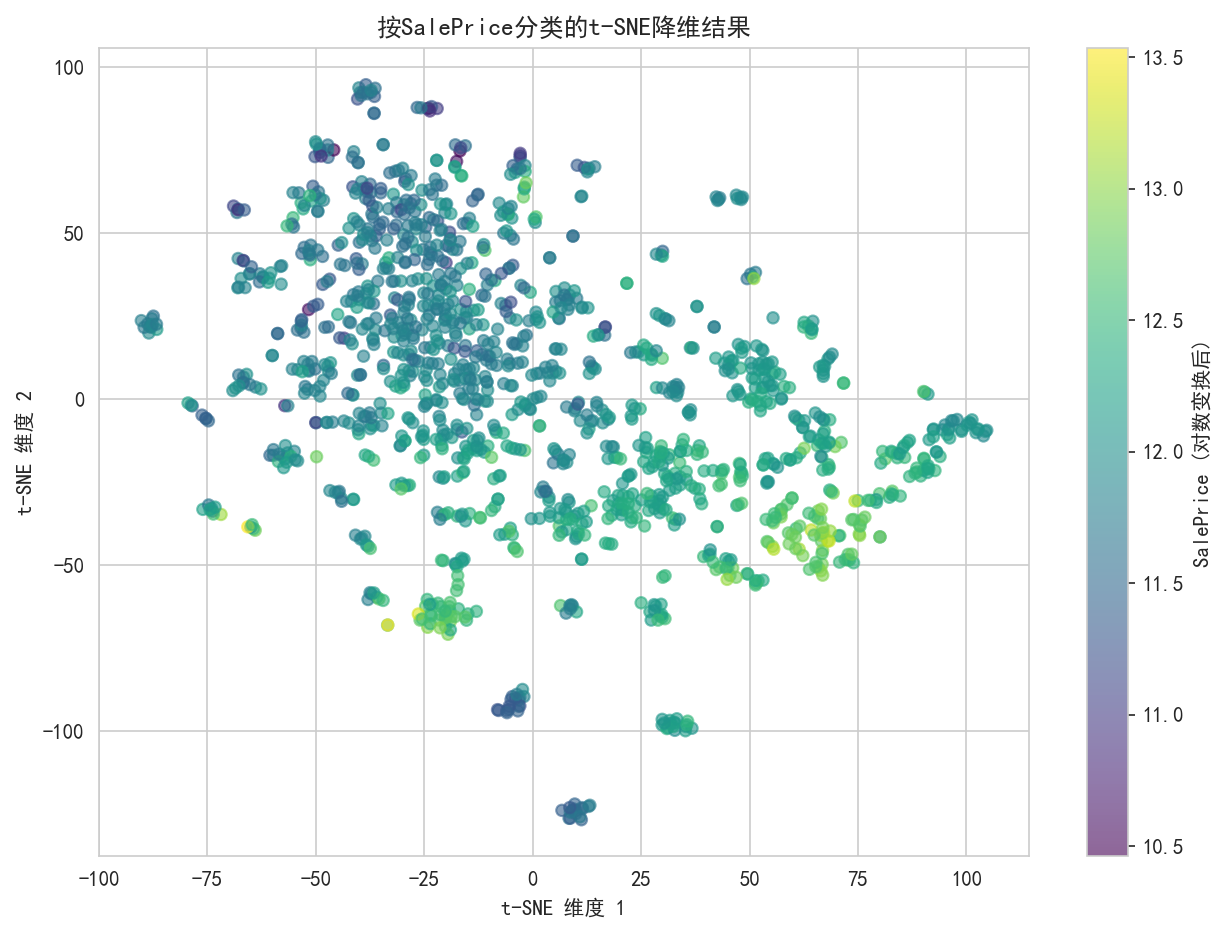

In [55]:
# 按SalePrice分类的t-SNE可视化
plt.figure(figsize=(10, 7))
scatter = plt.scatter(train_data_tsne[:, 0], train_data_tsne[:, 1], 
                     c=train_data['SalePrice'], cmap='viridis', s=30, alpha=0.6)
plt.xlabel('t-SNE 维度 1')
plt.ylabel('t-SNE 维度 2')
plt.title('按SalePrice分类的t-SNE降维结果')
plt.colorbar(scatter, label='SalePrice (对数变换后)')
plt.grid(True)
plt.savefig('../images/tsne_by_saleprice.png', bbox_inches='tight')
plt.show()

In [56]:
# 保存预处理后的数据
print("保存预处理后的数据...")

# 准备要保存的数据
processed_data = {
    'X_train': train_data_scaled,
    'X_test': test_data_scaled,
    'y_train': train_data['SalePrice'].values,
    'feature_names': all_data.columns.tolist(),
    'scaler': scaler,
    'train_indices': np.arange(len(train_data)),
    'test_indices': np.arange(len(train_data), len(train_data) + len(test_data)),
    'tsne_result': train_data_tsne,
    'original_target': original_target.values
}

# 保存到pickle文件
joblib.dump(processed_data, '../data/processed_data.pkl', compress=3)
print("预处理数据已保存到 '../data/processed_data.pkl'")

# 显示保存的数据信息
print("\n保存的数据包含:")
for key, value in processed_data.items():
    if hasattr(value, 'shape'):
        print(f"- {key}: {value.shape}")
    elif isinstance(value, list):
        print(f"- {key}: {len(value)} items")
    else:
        print(f"- {key}: {type(value)}")

保存预处理后的数据...
预处理数据已保存到 '../data/processed_data.pkl'

保存的数据包含:
- X_train: (1460, 287)
- X_test: (1459, 287)
- y_train: (1460,)
- feature_names: 287 items
- scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
- train_indices: (1460,)
- test_indices: (1459,)
- tsne_result: (1460, 2)
- original_target: (1460,)
